# Overview

## Description

This challenge serves as final project for the "[How to win a data science competition](https://www.coursera.org/learn/competitive-data-science/home/welcome)" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - [1C Company](http://1c.ru/eng/title.htm). 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

## Evaluation

Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

**Submission File**

For each id in the test set, you must predict a total number of sales. The file should contain a header and have the following format:

```
ID,item_cnt_month
0,0.5
1,0.5
2,0.5
3,0.5
etc.
```|

---

# Data Description

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

## File descriptions

- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

## Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category
- This dataset is permitted to be used for any purpose, including commercial use.

# Code Process
1. import library
2. Understanding the data
3. Data preprocessing
4. Test data processing
5. Model design
6. Hyper parameter tuning
7. Submission (1) 

# Import library

In [1]:
import os
from os.path import join

import pandas as pd
import numpy as np

# 데이터 결측치 확인
import missingno as msno

# models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import SGDRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
# from random import *

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Understanding the data

## Load data

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/first_kaggle_future_sales/data'

sales_train_path = join(data_dir, 'sales_train.csv')
items_path = join(data_dir, 'items.csv')
test_path = join(data_dir, 'test.csv')

sales_train = pd.read_csv(sales_train_path)
items = pd.read_csv(items_path)
test = pd.read_csv(test_path)

In [4]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [5]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [6]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


# Data preprocessing

In [7]:
# 원본 유지를 위해 data로 복사
data = sales_train.copy()

# 사용하지 않는 column 삭제
del data['date']
del data['item_price']

data

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
1,0,25,2552,1.0
2,0,25,2552,-1.0
3,0,25,2554,1.0
4,0,25,2555,1.0
...,...,...,...,...
2935844,33,25,7409,1.0
2935845,33,25,7460,1.0
2935846,33,25,7459,1.0
2935847,33,25,7440,1.0


In [8]:
# date, shop, item으로 묶어 월판매량을 구한다.
data = data.groupby(['date_block_num', 'shop_id', 'item_id'],
                    as_index=False).agg({'item_cnt_day': sum})
data

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0


In [9]:
# column 이름 정리
data.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']
data

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0


In [10]:
# category_id를 추가하고 item_name은 삭제
data = pd.merge(data, items, on='item_id', how='left')
del data['item_name']
data

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id
0,0,0,32,6.0,40
1,0,0,33,3.0,37
2,0,0,35,1.0,40
3,0,0,43,1.0,40
4,0,0,51,2.0,57
...,...,...,...,...,...
1609119,33,59,22087,6.0,83
1609120,33,59,22088,2.0,83
1609121,33,59,22091,1.0,83
1609122,33,59,22100,1.0,42


<AxesSubplot:>

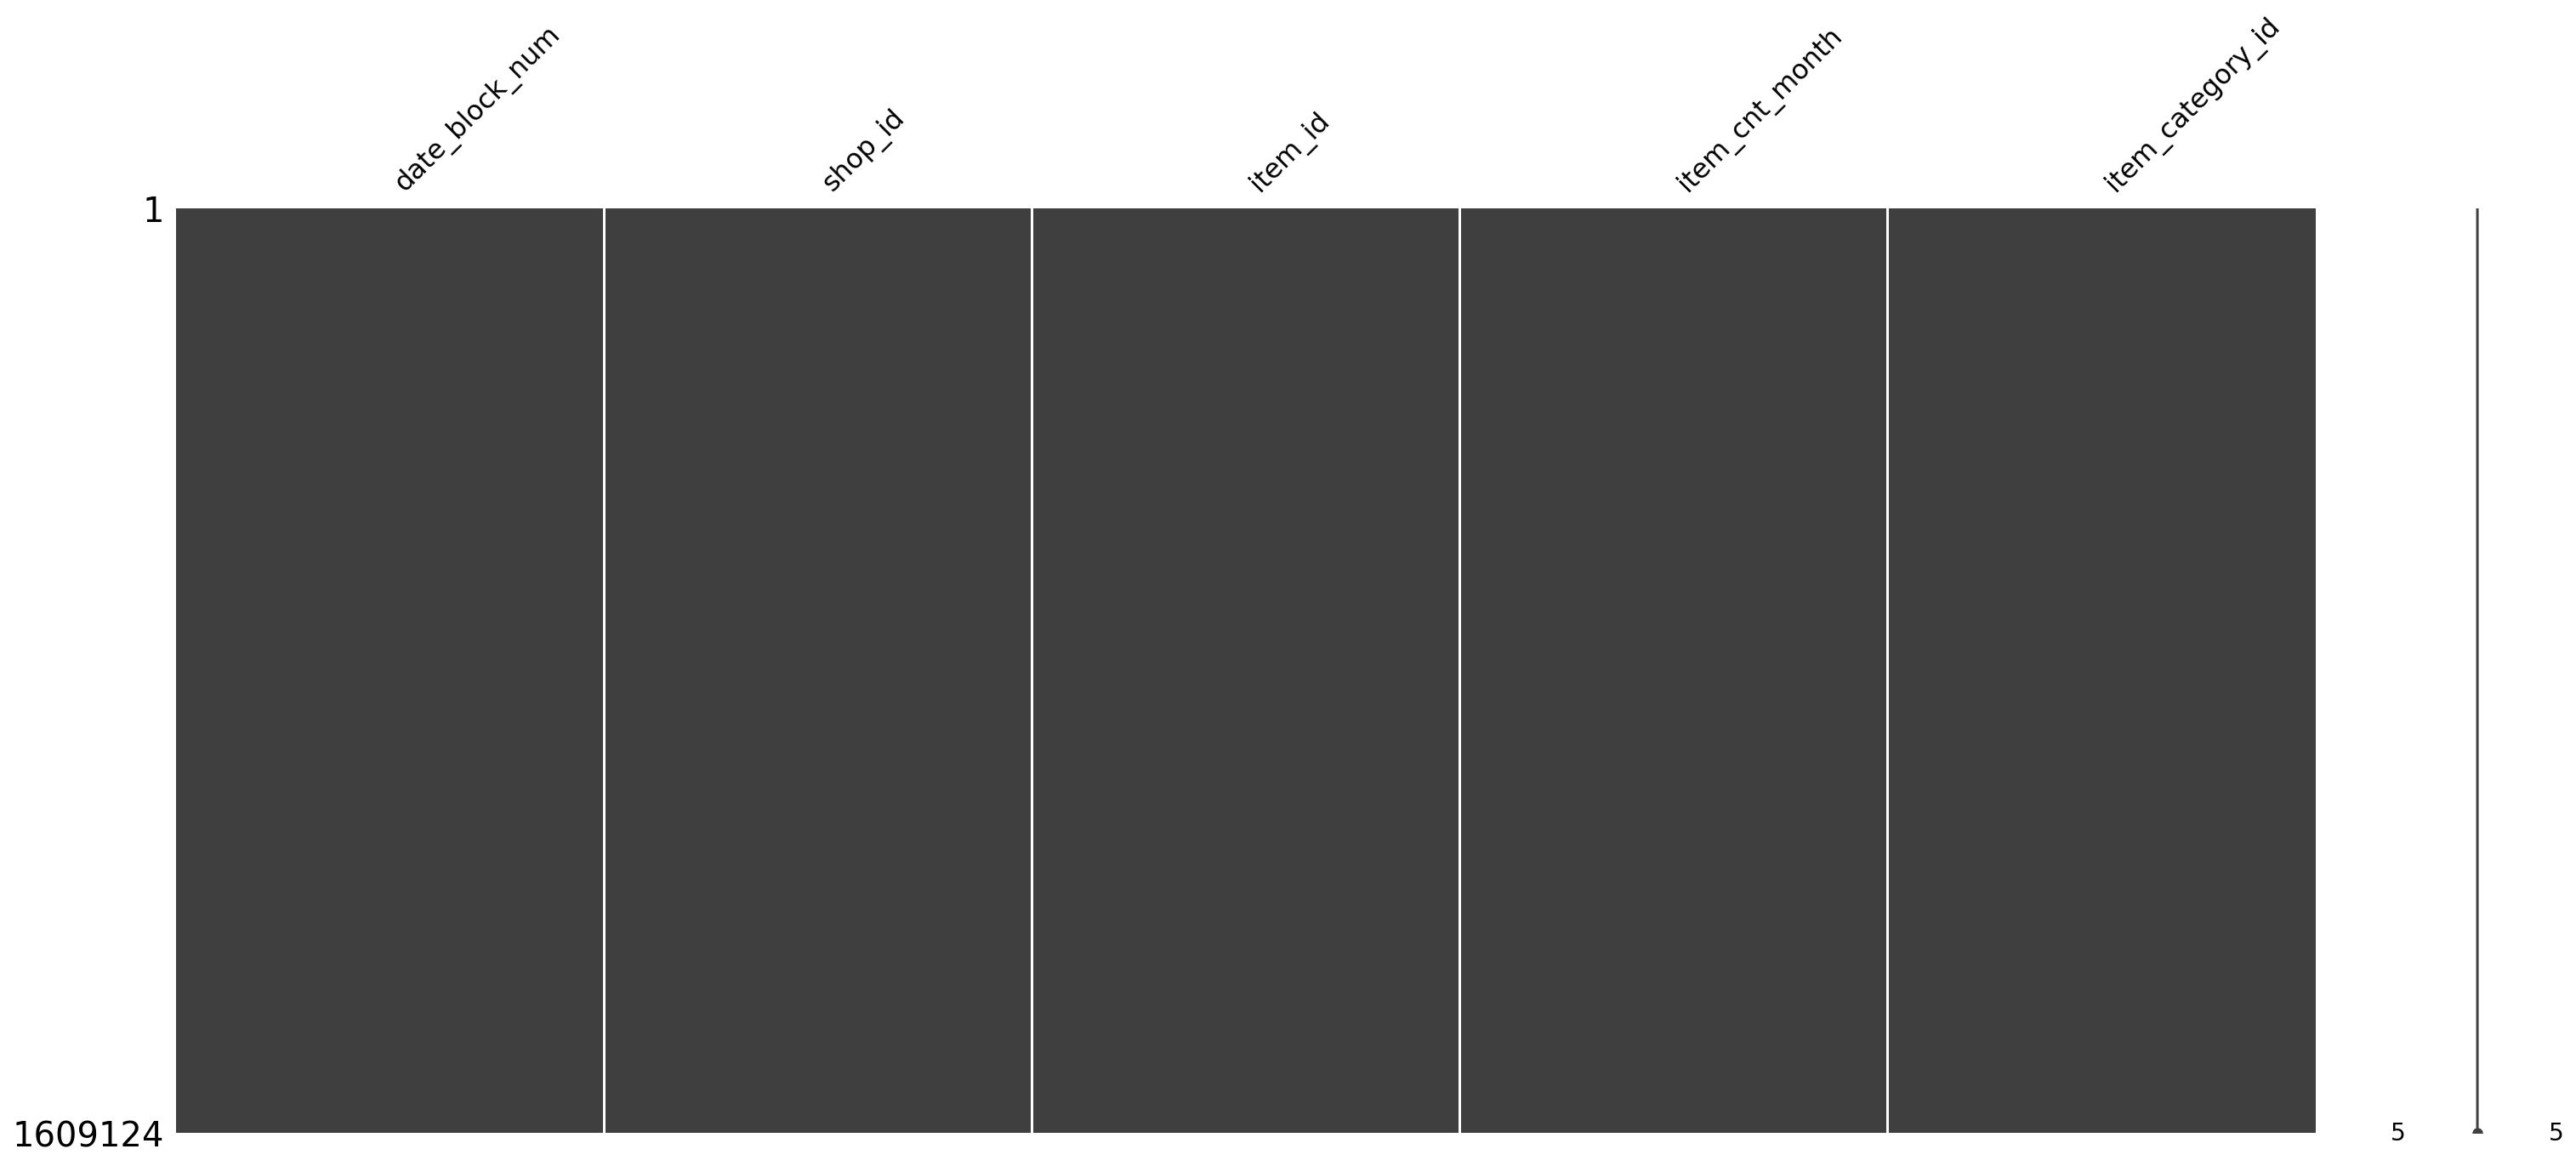

In [11]:
# 데이터 결측 상태 시각화
msno.matrix(data)

In [12]:
# 데이터 결측치 확인
for c in data.columns:
    print(f'{c}: {len(data.loc[pd.isnull(data[c]), c].values)}')

date_block_num: 0
shop_id: 0
item_id: 0
item_cnt_month: 0
item_category_id: 0


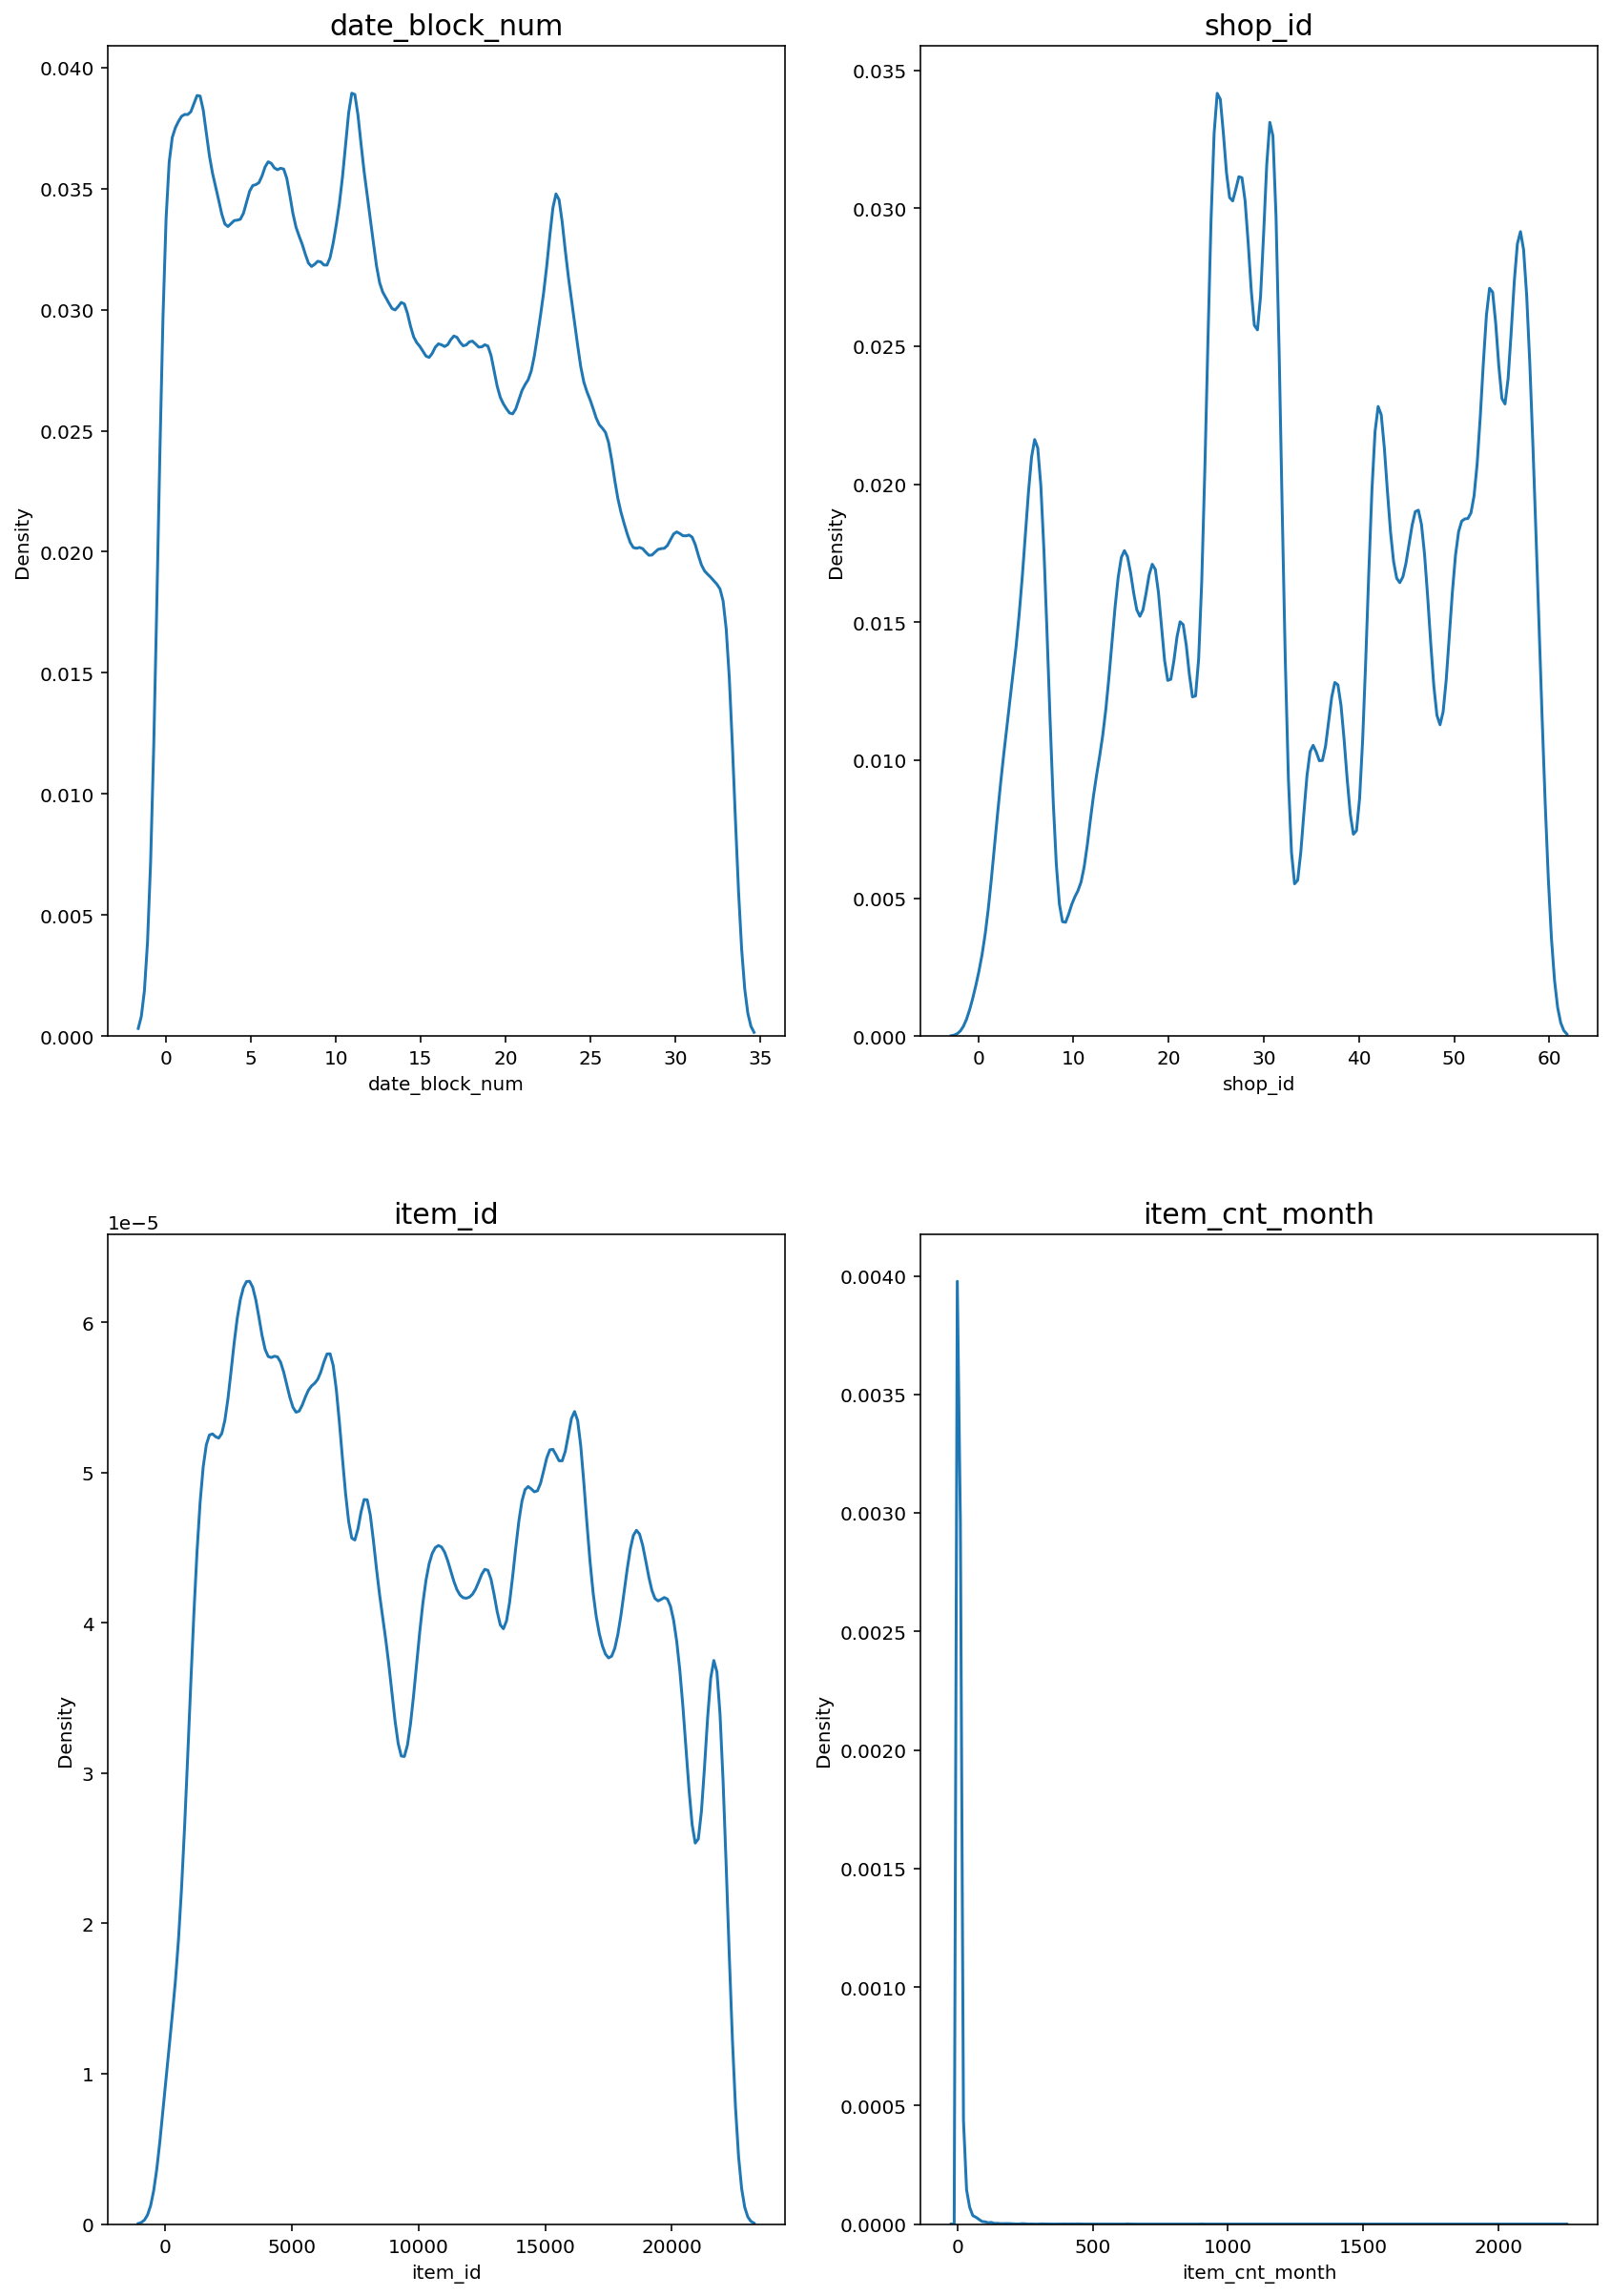

In [13]:
#각 변수들의 분포를 확인한다.
fig, ax = plt.subplots(2, 2, figsize=(14, 21))
count = 0
for row in range(2):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[data.columns[count]], ax=ax[row][col])
        ax[row][col].set_title(data.columns[count], fontsize=15)
        count += 1

In [14]:
y = data['item_cnt_month']
del data['item_cnt_month']

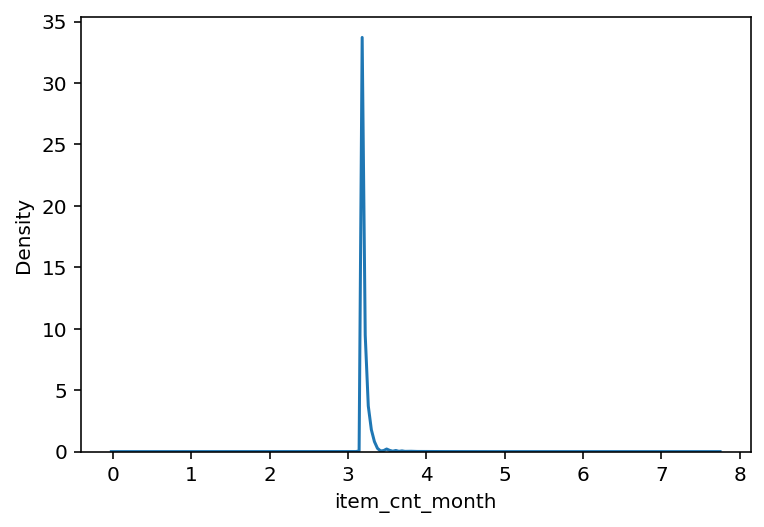

In [15]:
# item_cnt_month 변수가 한 쪽으로 치우쳐 있으므로 로그 변환
y = np.log(y+23)
sns.kdeplot(y)
plt.show()

In [21]:
# data nomarlization을 위해
transformer = Normalizer().fit(data)

In [ ]:
# import numpy as np
# np.random.seed(3000)
# data = np.random.randn(100)  # 평균 0, 표준편차 1의 분포에서 100개의 숫자를 샘플링한 데이터 생성
# data = np.concatenate((data, np.array([8, 10, -3, -5])))      # [8, 10, -3, -5])를 데이터 뒤에 추가함
# data

In [ ]:
# fig, ax = plt.subplots()
# ax.boxplot(data)
# plt.show()

In [ ]:
# Q3, Q1 = np.percentile(data, [75 ,25])
# IQR = Q3 - Q1
# IQR #데이터 중간 범위

In [ ]:
# data[(Q1-1.5*IQR > data)|(Q3+1.5*IQR < data)] #이상치

In [ ]:
# oulier_idx = data(df=data, column='shop_id', weight=1.5)
# df.drop(outlier_idx, axis=0, inplace=True) 

## Test data processing

In [22]:
test_copy = test.copy()
del test_copy['ID']

# 예측할 날짜
test_copy.loc[:, 'date_block_num'] = 34

# item_category_id 추가
test_copy = pd.merge(test_copy, items, on='item_id', how='left')
del test_copy['item_name']

# column 순서 수정
test_copy = test_copy[['date_block_num','shop_id', 'item_id','item_category_id']]
test_copy

,date_block_num,shop_id,item_id,item_category_id
0,34,5,5037,19
1,34,5,5320,55
2,34,5,5233,19
3,34,5,5232,23
4,34,5,5268,20
...,...,...,...,...
214195,34,45,18454,55
214196,34,45,16188,64
214197,34,45,15757,55
214198,34,45,19648,40


# Model design

In [23]:
# RMSE
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [24]:
random_state = 0

In [25]:
# models
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)
sgd = SGDRegressor(random_state=random_state)

# models = [gboost, xgboost, lightgbm, rdforest, sgd]
models = [sgd, lightgbm, xgboost,gboost]

In [26]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(
            train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values(
            'RMSE', ascending=False)

    return score_df

In [27]:
# get_scores([xgboost], transformer.transform(data), y)
get_scores([xgboost], data, y)

,RMSE
XGBRegressor,6.257227


# Submission

In [28]:
prediction = xgboost.predict(test_copy)

In [29]:
prediction

array([3.1879108, 3.2075515, 3.1966748, ..., 3.1793804, 3.182728 ,
       3.1782115], dtype=float32)

In [30]:
data_dir = os.getenv('HOME')+'/aiffel/first_kaggle_future_sales/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [31]:
result = pd.DataFrame({ 
    'item_cnt_month' : prediction
})

result.head()

,item_cnt_month
0,3.187911
1,3.207551
2,3.196675
3,3.195553
4,3.201158


In [32]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/home/aiffel-dj54/aiffel/first_kaggle_future_sales/data/submission.csv


# Hyper parameter tuning

In [33]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [34]:
param_grid = {'max_iter':[1000,2000]}

grid_search = GridSearchCV(sgd,
                           param_grid,
                           scoring='neg_mean_squared_error',
                           n_jobs=5,
                           cv=5,
                           verbose=2,
                           return_train_score=True)

In [35]:
model = SGDRegressor(random_state=random_state)

print('얍💢')

얍💢


In [36]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(data, y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed: 14.0min finished


GridSearchCV(cv=5, estimator=SGDRegressor(random_state=0), n_jobs=5,
             param_grid={'max_iter': [1000, 2000]},
             scoring='neg_mean_squared_error', verbose=1)

In [37]:
get_scores([sgd], data, y)

,RMSE
SGDRegressor,26.683317


In [38]:
prediction_1 = grid_model.predict(test_copy)
prediction_1

array([-1.57815624e+15, -1.66778190e+15, -1.63966665e+15, ...,
       -4.94858162e+15, -6.16935045e+15, -3.07277663e+14])

In [39]:
prediction_1 = np.expm1(prediction_1)
prediction_1

array([-1., -1., -1., ..., -1., -1., -1.])

In [40]:
#샘플데이터 가져와서 형식 맞추기 
data_dir = os.getenv('HOME')+'/aiffel/first_kaggle_future_sales/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [43]:
submission['item_cnt_month'] = prediction_1
submission.head()

,ID,item_cnt_month
0,0,-1.0
1,1,-1.0
2,2,-1.0
3,3,-1.0
4,4,-1.0


In [44]:
my_submission_path = join(data_dir, 'submission.csv')
submission.to_csv(my_submission_path, index=False)

print(my_submission_path)

/home/aiffel-dj54/aiffel/first_kaggle_future_sales/data/submission.csv
